# Preprocessing
This script loads the images and crops them down multiple times for each cell, that is contained in the image.

In [ ]:
import numpy as np
import os
from pathlib import Path
from PIL import Image
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms as T
import torch
import random
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [6]:
# ------------  CONFIG  -------------------
base_path = '/scratch/cv-course-group-5/data/dataset_jpg'
TARGET_SIZE = 224
src_root   = Path(base_path + '/dataset')
dst_root   = Path(base_path + '/preprocessed_dataset')
anno_file  = Path(base_path + '/dataset/annotations.json')

## Crop images

In [7]:
# load annotations
annos_dict = json.loads(anno_file.read_text())

annos = annos_dict.get('annotations', [])
videos = annos_dict.get('videos', [])
images = annos_dict.get('images', [])

video_id2name = {v["id"]: v["name"] for v in videos}
image_by_id = {img["id"]: img for img in images} 

In [8]:
# reorder annotations in new dictionary
annos_sorted = {}

for ann in annos:
    video_id = ann["video_id"]
    image_id = ann["image_id"]

    frame_nmbr = image_by_id[image_id]['file_name'][-7:-4]
    video_name = video_id2name[video_id]
    
    # if there is no entry yet in the dictionary
    if video_name not in annos_sorted:
        annos_sorted[video_name] = {}
    if frame_nmbr not in annos_sorted[video_name]:
        annos_sorted[video_name][frame_nmbr] = []

    # add annotation
    annos_sorted[video_name][frame_nmbr].append(ann)

In [9]:
video_folder_list = os.listdir(src_root)
video_folder_list = [f for f in video_folder_list if f != 'annotations.json']
video_folder_list = sorted(video_folder_list, key=lambda x: int(x))

In [ ]:
# missing folder names in annotations (written manually)
missing_folders = ['052', '060', '160', '256', '265']

In [ ]:
for _, vid_name in tqdm(enumerate(video_folder_list), total=len(video_folder_list), ncols=100, position=0):

    # define paths for specific video folder
    org_video_folder = src_root / vid_name / 'images'
    dst_video_folder = dst_root / vid_name / 'images'

    if os.path.exists(dst_video_folder):
        continue
    else:
        dst_video_folder.mkdir(parents=True, exist_ok=True)
    
    try:
        annos_by_frame = annos_sorted[vid_name]
    except KeyError:
        print(vid_name)
        continue 

    # iterate over every image file in that folder
    for img_path in sorted(org_video_folder.glob("*.jpg")):
        # frame index is the last 3 digits in “…t086.jpg”
        frame_idx = img_path.stem[-3:]

        # skip if no cells in this frame
        if frame_idx not in annos_by_frame:
            print(img_path)
            continue
        
        img = Image.open(img_path).convert("RGB")

        for ann in annos_by_frame[frame_idx]:
            cell_id = str(ann['cell_id'])
            x_c, y_c, w, h = ann['bbox']

            # calculate values for cropping
            left   = int(x_c - w / 2)
            upper  = int(y_c - h / 2)
            right  = int(x_c + w / 2)
            lower  = int(y_c + h / 2)

            crop = img.crop((left, upper, right, lower))

            # resize image if it is larger than the Target size
            if crop.width > TARGET_SIZE or crop.height > TARGET_SIZE:
                scale = TARGET_SIZE / max(crop.width, crop.height)
                new_size = (int(crop.width  * scale), int(crop.height * scale))
                crop = crop.resize(new_size, Image.BICUBIC)

            # put image on black background of Target size
            canvas = Image.new("RGB", (TARGET_SIZE, TARGET_SIZE), (0, 0, 0))  # black background
            x_off = (TARGET_SIZE - crop.width)  // 2
            y_off = (TARGET_SIZE - crop.height) // 2
            canvas.paste(crop, (x_off, y_off))

            # plt.imshow(canvas)
            # plt.title('Video: ' + vid_id_test + ', Frame: ' + frame_idx + ', Cell_Id: ' + cell_id)
            # plt.show()

            # save cropped and resized image
            save_name  = f"v{vid_name}_f{frame_idx}_c{cell_id.zfill(3)}.jpg"
            canvas.save(dst_video_folder / save_name)

100%|█████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.70s/it]


## Train Test Split

In [ ]:
videos_split = [{k: v[k] for k in ['id', 'name']} for v in videos if v['name'] not in missing_folders]

test_size = int(len(videos_split) * 0.2)
val_size = int(len(videos_split) * 0.8 * 0.2)

test_videos = []
val_videos = []

random.seed(42)

for i in range(test_size):
    test_videos.append(videos.pop(random.randint(0, len(videos) - 1)))

for i in range(val_size):
    val_videos.append(videos.pop(random.randint(0, len(videos) - 1)))

def sort(video):
    return video['id']

train_videos = videos
test_videos.sort(key=sort)
val_videos.sort(key=sort)

print(f"Train ({len(train_videos)}): {train_videos}")
print(f"Test ({len(test_videos)}):   {test_videos}")
print(f"Validation ({len(val_videos)}):   {val_videos}")

train_test_split = {'train': train_videos, 'test': test_videos, 'val': val_videos}

json.dump(train_test_split, open(base_path + '/train_test_split.json', 'w'))

## Calculate mean and std for Dataset

In [40]:
class CellDataset(Dataset):
    def __init__(self, video_list, path_to_videos, transform):
        self.image_paths = []
        self.path_to_videos = path_to_videos
        self.transform = transform

        for video_dict in video_list:
            dst_path = path_to_videos / str(video_dict['name']) / 'images'
            self.image_paths += dst_path.glob('*.jpg')

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            view1 = self.transform(img)
            view2 = self.transform(img)
            return view1, view2

        return img

In [ ]:
# Path to your JSON file
json_path = Path(base_path + '/train_test_split.json')

# Load the file
with open(json_path, 'r') as f:
    split_data = json.load(f)

# Access the train and test entries
train_list = split_data.get("train", [])
train_list

[{'id': 1, 'name': 1},
 {'id': 3, 'name': 3},
 {'id': 4, 'name': 4},
 {'id': 5, 'name': 5},
 {'id': 6, 'name': 6},
 {'id': 8, 'name': 8},
 {'id': 9, 'name': 9},
 {'id': 10, 'name': 10},
 {'id': 11, 'name': 11},
 {'id': 12, 'name': 12},
 {'id': 14, 'name': 14},
 {'id': 19, 'name': 19},
 {'id': 20, 'name': 20},
 {'id': 21, 'name': 21},
 {'id': 22, 'name': 22},
 {'id': 23, 'name': 23},
 {'id': 25, 'name': 25},
 {'id': 26, 'name': 26},
 {'id': 30, 'name': 30},
 {'id': 34, 'name': 34},
 {'id': 35, 'name': 35},
 {'id': 36, 'name': 36},
 {'id': 37, 'name': 37},
 {'id': 38, 'name': 38},
 {'id': 40, 'name': 40},
 {'id': 42, 'name': 42},
 {'id': 43, 'name': 43},
 {'id': 44, 'name': 44},
 {'id': 48, 'name': 48},
 {'id': 49, 'name': 49},
 {'id': 50, 'name': 50},
 {'id': 51, 'name': 51},
 {'id': 53, 'name': 54},
 {'id': 55, 'name': 56},
 {'id': 56, 'name': 57},
 {'id': 57, 'name': 58},
 {'id': 60, 'name': 62},
 {'id': 61, 'name': 63},
 {'id': 62, 'name': 64},
 {'id': 63, 'name': 65},
 {'id': 65, 'n

In [45]:
# Simple transform to just convert to tensor
transform = transforms.ToTensor()
dataset = CellDataset(video_list=train_list, path_to_videos=dst_root, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [46]:
mean = 0.
std = 0.
nb_samples = 0.

for data in loader:
    img = data[0]  # assuming (batch, channels, height, width)
    batch_samples = img.size(0)
    img = img.view(batch_samples, img.size(1), -1)  # flatten HxW

    mean += img.mean(2).sum(0)
    std += img.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print('Mean:', mean)
print('Std:', std)

Mean: tensor([0.0027, 0.0059, 0.0032])
Std: tensor([0.0114, 0.0250, 0.0160])


In [58]:
json.dump({'mean': mean.tolist(), 'std': std.tolist()}, open(base_path + '/mean_std.json', 'w'))

## Analyse Large Cells

In [24]:
filtered_annos = [ann for ann in annos if ann['bbox'][2] > 400 or ann['bbox'][3] > 400]

# Step 1: Create a lookup from image_id to file_name
image_id_to_filename = {img["id"]: img["file_name"] for img in images}

# Step 2: Map filtered annotations to their filenames
for i in range(len(filtered_annos)):
    image_id = filtered_annos[i]['image_id']
    filename = image_id_to_filename.get(image_id, "UNKNOWN")
    filtered_annos[i]['filename'] = filename

In [25]:
filtered_annos

[{'id': 351503,
  'image_id': 9599,
  'video_id': 64,
  'cell_id': 55,
  'parent_label': 127,
  'category_id': 1,
  'first_frame': 0,
  'centroid': [709, 880],
  'bbox': [788, 899, 401, 248],
  'area': 99448,
  'iscrowd': 0,
  'time_of_death': None,
  'time_of_division': None,
  'time_step': 148,
  'filename': '066/images/xy066c0t149.jpg'},
 {'id': 586485,
  'image_id': 14038,
  'video_id': 94,
  'cell_id': 15,
  'parent_label': 14,
  'category_id': 1,
  'first_frame': 0,
  'centroid': [478, 487],
  'bbox': [521, 291, 146, 453],
  'area': 66138,
  'iscrowd': 0,
  'time_of_death': None,
  'time_of_division': None,
  'time_step': 87,
  'filename': '096/images/xy096c0t088.jpg'},
 {'id': 984204,
  'image_id': 22649,
  'video_id': 151,
  'cell_id': 10,
  'parent_label': 9,
  'category_id': 1,
  'first_frame': 0,
  'centroid': [173, 308],
  'bbox': [200, 340, 401, 153],
  'area': 61353,
  'iscrowd': 0,
  'time_of_death': 153,
  'time_of_division': None,
  'time_step': 148,
  'filename': '153

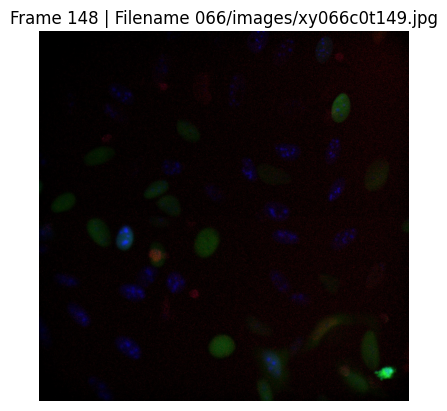

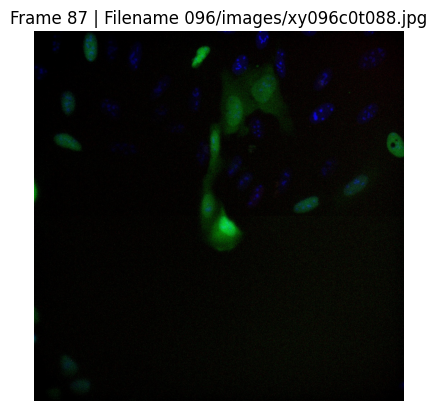

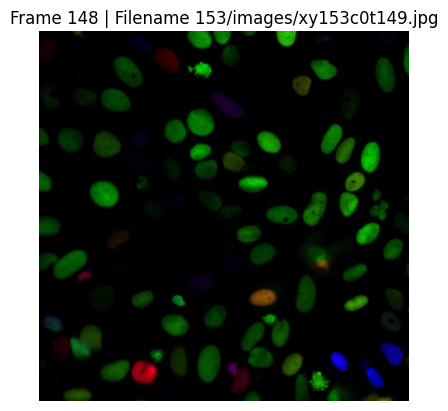

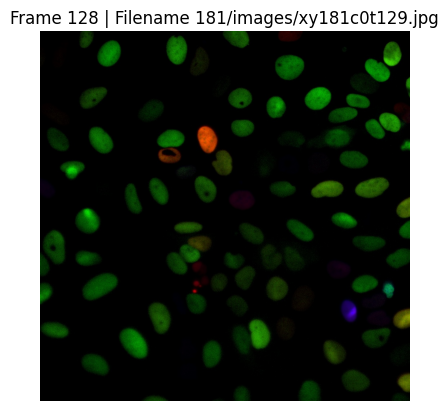

In [26]:
# How many full images to show
N = 20

for i, ann in enumerate(filtered_annos[:N]):
    file_path = os.path.join(src_root, ann["filename"])

    if not os.path.exists(file_path):
        print(f"Missing file: {file_path}")
        continue

    # Load full image
    img = Image.open(file_path).convert("RGB")

    # Show full image
    plt.imshow(img)
    plt.title(f"Frame {ann['time_step']} | Filename {ann['filename']}")
    plt.axis("off")
    plt.show()

In [32]:
root_dir = Path(dst_root)
jpg_files = list(root_dir.rglob("*.jpg"))
print("Number of .jpg files:", len(jpg_files))

Number of .jpg files: 2204912
